In [1]:
import torch
from utils import *
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

import csv

/home/shaw/anaconda3/envs/hw5/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def model_visualization2(srgan_generator, srgan2_checkpoint, HR_image_path, LR_image_path):
    hr_img = Image.open(HR_image_path, mode="r")
    hr_img = hr_img.convert('RGB')
    lr_img = Image.open(LR_image_path, mode="r")
    lr_img = lr_img.convert('RGB')

    # Bicubic Upsampling
    bicubic_img = lr_img.resize((hr_img.width, hr_img.height), Image.BICUBIC)

    # Super-resolution (SR) with SRGAN
    sr_img_srgan = srgan_generator(convert_image(lr_img, source='pil', target='imagenet-norm', device=device).unsqueeze(0).to(device))
    sr_img_srgan = sr_img_srgan.squeeze(0).detach()
    sr_img_srgan = convert_image(sr_img_srgan, source='[-1, 1]', target='pil', device=device)

    del lr_img
    lr_img = Image.open(LR_image_path, mode="r")
    lr_img = lr_img.convert('RGB')
    # Super-resolution (SR) with Pre-SRGAN
    sr_img_srgan2 = srgan2_checkpoint(convert_image(lr_img, source='pil', target='imagenet-norm', device=device).unsqueeze(0).to(device))
    sr_img_srgan2 = sr_img_srgan2.squeeze(0).detach()
    sr_img_srgan2 = convert_image(sr_img_srgan2, source='[-1, 1]', target='pil', device=device)

    image_name = os.path.basename(HR_image_path)
    # Visualization
    plt.figure(figsize=(20,6), dpi=100)
    plt.rcParams['font.sans-serif']=['SimHei']

    plt.subplot(141)
    plt.imshow(bicubic_img)
    plt.axis('off')
    plt.title('Bicubic: {}'.format(image_name), y = -0.08, fontsize = 18)

    plt.subplot(142)
    plt.imshow(sr_img_srgan)
    plt.axis('off')
    plt.title('SRGAN: {}'.format(image_name), y = -0.08, fontsize = 18)

    plt.subplot(143)
    plt.imshow(sr_img_srgan2)
    plt.axis('off')
    plt.title('SRGAN2: {}'.format(image_name), y = -0.08, fontsize = 18)

    plt.subplot(144)
    plt.imshow(hr_img)
    plt.axis('off')
    plt.title('Original HR: {}'.format(image_name), y = -0.08, fontsize = 18)
    plt.show()

/tmp/ipykernel_417550/484711365.py:8: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  bicubic_img = lr_img.resize((hr_img.width, hr_img.height), Image.BICUBIC)


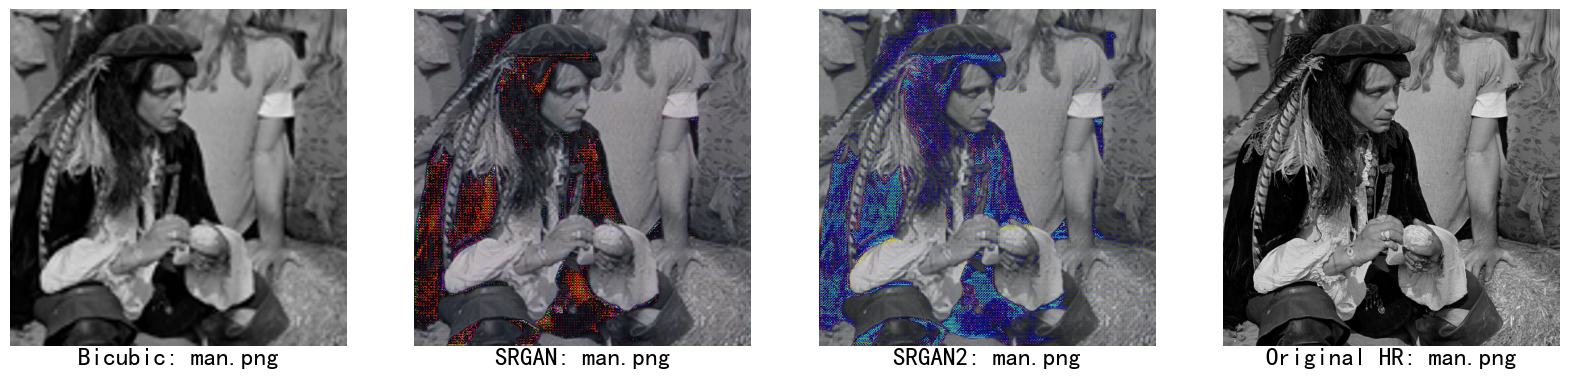

OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 7.80 GiB total capacity; 522.24 MiB already allocated; 37.25 MiB free; 586.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [3]:
# train model 
srgan_checkpoint = "./output/1/checkpoint_srgan.50.pth.tar"
# Load models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
srgan_generator = torch.load(srgan_checkpoint)['generator'].to(device)
srgan_generator.eval()

# pre-train model 
srgan2_checkpoint = "./output/2/checkpoint_srgan.150.pth.tar"
# Load pre-models
srgan2_generator = torch.load(srgan2_checkpoint)['generator'].to(device)
srgan2_generator.eval()

image_folder = './SRDataset/benchmark/Set14/'
image_csv_folder='./SRDataset/Set14_images.csv'

with open(image_csv_folder, 'r') as f:
    reader = csv.reader(f)
    for line in reader:
        HR_image_path = os.path.join(image_folder,'HR',line[0])
        LR_image_path = os.path.join(image_folder,'LR_bicubic/X4',line[1])
        model_visualization2(srgan_generator, srgan2_generator, HR_image_path, LR_image_path)